This demo shows how to use integrated gradients in graph convolutional networks to obtain accurate importance estimations for both the nodes and edges. The notebook consists of three parts:
- setting up the node classification problem for Cora citation network
- training and evaluating a GraphSAGE model for node classification
- calculating node and edge importances for model's predictions of query ("target") nodes

<a name="refs"></a>
**References**

[1] Axiomatic Attribution for Deep Networks. M. Sundararajan, A. Taly, and Q. Yan.
    Proceedings of the 34th International Conference on Machine Learning, Sydney, Australia, PMLR 70, 2017
    ([link](https://arxiv.org/pdf/1703.01365.pdf)).
    
[2] Adversarial Examples on Graph Data: Deep Insights into Attack and Defense. H. Wu, C. Wang, Y. Tyshetskiy, A. Docherty, K. Lu, and L. Zhu. arXiv: 1903.01610 ([link](https://arxiv.org/abs/1903.01610)).

Import NetworkX and stellar:

In [1]:
import networkx as nx
import pandas as pd
import os
import numpy as np
import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from copy import deepcopy

from tensorflow.keras import backend as K
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz).

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = os.path.expanduser("~/data/cora")

Load the graph from edgelist (in `cited-paper` <- `citing-paper` order)

In [3]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

The adjacency matrix is ordered by the graph nodes from G.nodes(). To make computations easier, let's reindex the node data to maintain the same ordering.

In [7]:
graph_nodes = list(Gnx.nodes())
node_data = node_data.loc[graph_nodes]

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [8]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this

In [9]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=0.1, test_size=None, stratify=node_data['subject'])

Note using stratified sampling gives the following counts:

In [10]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Neural_Networks': 81,
         'Probabilistic_Methods': 42,
         'Genetic_Algorithms': 42,
         'Reinforcement_Learning': 22,
         'Rule_Learning': 18,
         'Case_Based': 30,
         'Theory': 35})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [11]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))
all_targets = target_encoding.transform(
        node_data[["subject"]].to_dict("records")
    )

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [12]:
node_features = node_data[feature_names]

## Creating the GraphSAGE model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [13]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [14]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



To feed data from the graph to the Keras model we need a data generator that feeds data from the graph to the model. The generators are specialized to the model and the learning task so we choose the `GraphSAGENodeGenerator` as we are predicting node attributes with a GraphSAGE model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second.

In [15]:
batch_size = 20; num_samples = [10, 5]

A `GraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [16]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [17]:
train_gen = generator.flow(train_data.index, train_targets, shuffle=True)
test_gen = generator.flow(test_data.index, test_targets)
all_gen = generator.flow(graph_nodes)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [18]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32],
    generator=generator,
    bias=True,
    dropout=0.5,
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Now we create a model to predict the 7 categories using Keras softmax layers.

In [19]:
x_inp, x_out = graphsage_model.build()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [20]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [21]:
history = model.fit_generator(
    train_gen,
    epochs=10,
    validation_data=test_gen,
    verbose=2,
    shuffle=False
)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
14/14 - 2s - loss: 1.8840 - acc: 0.2481 - val_loss: 1.6702 - val_acc: 0.3737
Epoch 2/10
14/14 - 2s - loss: 1.5536 - acc: 0.5333 - val_loss: 1.4387 - val_acc: 0.6066
Epoch 3/10
14/14 - 2s - loss: 1.3083 - acc: 0.7000 - val_loss: 1.2217 - val_acc: 0.6661
Epoch 4/10
14/14 - 2s - loss: 1.0640 - acc: 0.8222 - val_loss: 1.0581 - val_acc: 0.7063
Epoch 5/10
14/14 - 2s - loss: 0.8752 - acc: 0.8593 - val_loss: 0.9296 - val_acc: 0.7830
Epoch 6/10
14/14 - 2s - loss: 0.7103 - acc: 0.9370 - val_loss: 0.8355 - val_acc: 0.7953
Epoch 7/10
14/14 - 2s - loss: 0.5759 - acc: 0.9704 - val_loss: 0.7713 - val_acc: 0.8060
Epoch 8/10
14/14 - 2s - loss: 0.4962 - acc: 0.9556 - val_loss: 0.7277 - val_acc: 0.8048
Epoch 9/10
14/14 - 2s - loss: 0.3816 - acc: 0.9963 - val_loss: 0.6990 - val_acc: 0.8076
Epoch 10/10
14/14 - 2s - loss: 0.3321 - acc: 0.9926 - val_loss: 0.6855 - val_acc: 0.7990


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()

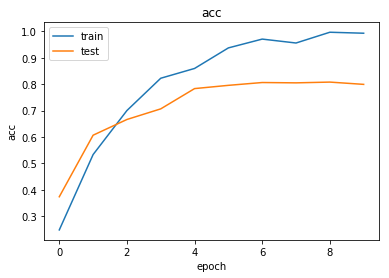

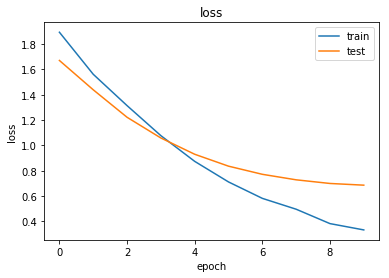

In [23]:
plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [24]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))



Test Set Metrics:
	loss: 0.6770
	acc: 0.8019


# Node and link importance via saliency maps

Now we define the importances of node features, nodes, and links in the target node's neighbourhood (ego-net), and evaluate them using our library.

Node feature importance: given a target node $t$ and the model's prediction of $t$'s class, for each node $v$ in its ego-net, feature importance of feature $f$ for node $v$ is defined as the change in the target node's predicted score $s(c)$ for the winning class $c$ if feature $f$ of node $v$ is perturbed.

The overall node importance for node $v$ is defined here as the sum of all feature importances for node $v$, i.e., it is the amount by which the target node's predicted score $s(c)$ would change if we set all features of node $v$ to zeros.

Link importance for link $e=(u, v)$ is defined as the change in target node $t$'s predicted score $s(c)$ if the link $e$ is removed from the graph. Links with high importance (positive or negative) affect the target node prediction more than links with low importance.

Node and link importances can be used to assess the role of neighbour nodes and links in model's predictions for the node(s) of interest (the target nodes). For datasets like CORA-ML, the features and edges are binary, vanilla gradients may not perform well so we use integrated gradients to compute them (https://arxiv.org/pdf/1703.01365.pdf).

In [25]:
from stellargraph.utils.saliency_maps import IntegratedGradientsGSAGE
from stellargraph.utils.saliency_maps import GradientSaliencyGSAGE

Select the target node whose prediction is to be interpreted

In [26]:
target_idx = 7   # index of the selected node in G.nodes()
target_nid = graph_nodes[target_idx] # Node ID of the selected node
y_true = all_targets[target_idx]  # true class of the target node

In [27]:
target_gen = generator.flow([graph_nodes[target_idx]])
y_pred = model.predict_generator(target_gen)
class_of_interest = np.argmax(y_pred)

print("Selected node id: {}, \nTrue label: {}, \nPredicted scores: {}".format(target_nid, y_true, y_pred.round(2)))

Selected node id: 1109199, 
True label: [0. 1. 0. 0. 0. 0. 0.], 
Predicted scores: [[0.02 0.81 0.03 0.02 0.06 0.02 0.03]]


Test of generating random subgraph

In [28]:
sub_feat = []
sub_node_idx = []
for i in range(10):
    ss = target_gen.__getitem__(0)
    sub_feat.append(target_gen.batch_features)
    sub_node_idx.append(target_gen.batch_nodes_indices)

Get the node feature importance by using integrated gradients

In [29]:
int_grad_saliency = IntegratedGradientsGSAGE(model, target_gen)
saliency = GradientSaliencyGSAGE(model, target_gen)

Get the ego network of the target node.

In [30]:
G_ego = nx.ego_graph(G, target_nid, radius=len(graphsage_model.layer_sizes))

Compute the node importance by expected integrated gradients.

In [31]:
print(class_of_interest)
integrated_node_importance = int_grad_saliency.expected_node_importance(class_of_interest, ig_steps=25, exp_steps=1000)
print('integrated self-importance of target node {}: {}'.format(target_nid, integrated_node_importance[target_nid].round(2)))

1
integrated self-importance of target node 1109199: -0.01


Compute the link importance by expected integrated gradients.

In [32]:
integrated_link_importance = int_grad_saliency.expected_link_importance(class_of_interest, ig_steps=25, exp_steps=1000)
print("\nEgo net of target node {} has {} nodes".format(target_nid, G_ego.number_of_nodes()))
print("\nEgo net of target node {} has {} edges".format(target_nid, G_ego.number_of_edges()))


Ego net of target node 1109199 has 202 nodes

Ego net of target node 1109199 has 401 edges


Get the ranks of the edge importance values.

In [33]:
sorted_link_importance = sorted(integrated_link_importance.items(),key=lambda item:item[1], reverse=True)
sorted_node_importance = sorted(integrated_node_importance.items(),key=lambda item:item[1], reverse=True)
print(len(sorted_node_importance))
print(len(sorted_link_importance))

202
207


In [34]:
topk = 10
print('Top {} most important nodes by integrated gradients are {}'.format(topk, sorted_node_importance[:topk]))
print('Top {} most important links by integrated gradients are {}'.format(topk, sorted_link_importance[:topk]))

Top 10 most important nodes by integrated gradients are [(35, 0.4695300442167372), (148170, 0.18428617572016975), (1128997, 0.10201407914464268), (1115886, 0.007586711392934454), (23258, 0.0053881708350280175), (579008, 0.0031322111012990765), (28447, 0.0028457756028459377), (646809, 0.0027612279790537528), (28851, 0.0027439833191063357), (787016, 0.0027431517659029844)]
Top 10 most important links by integrated gradients are [((1109199, 35), 0.3408578998665814), ((1109199, 148170), 0.18181651315033925), ((148170, 35), 0.12477807888052363), ((148170, 1128997), 0.10426643071461086), ((6214, 1115886), 0.007422623786615731), ((6214, 23258), 0.005183445701445598), ((35, 579008), 0.00290923452291645), ((35, 646809), 0.0028194433700545057), ((6214, 28447), 0.0027577208110882213), ((35, 503883), 0.0027417325458140842)]


In the following, we plot the link and node importance (computed by integrated gradients) of the nodes within the ego graph of the target node.

For nodes, the shape of the node indicates the positive/negative importance the node has. 'round' nodes have positive importance while 'diamond' nodes have negative importance. The size of the node indicates the value of the importance, e.g., a large diamond node has higher negative importance.

For links, the color of the link indicates the positive/negative importance the link has. 'red' links have positive importance while 'blue' links have negative importance. The width of the link indicates the value of the importance, e.g., a thicker blue link has higher negative importance.

In [35]:
nx.set_node_attributes(G_ego, values={x[0]:{'subject': x[1]} for x in node_data['subject'].items()})

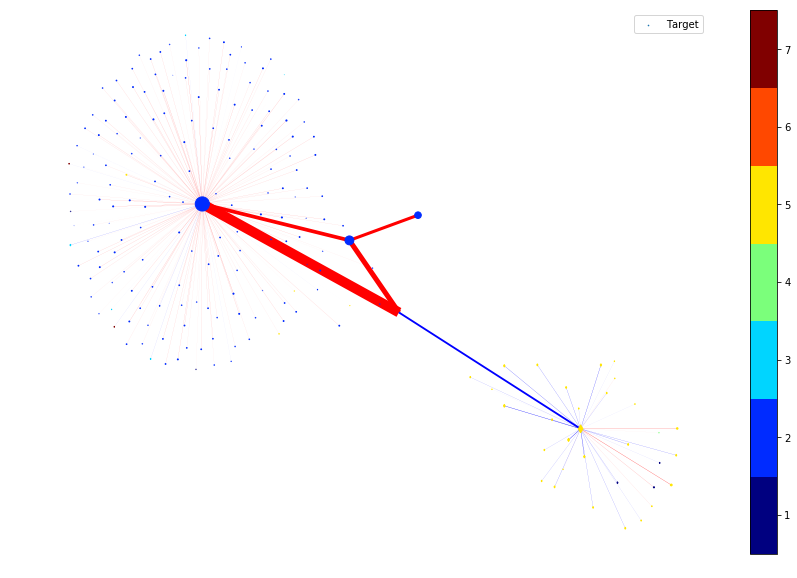

In [36]:
node_size_factor = 2e2
link_width_factor = 10

nodes = list(G_ego.nodes())
colors = pd.DataFrame([v[1]['subject'] for v in G_ego.nodes(data=True)], 
                      index=nodes, columns=['subject'])
colors = np.argmax(target_encoding.transform(colors.to_dict('records')), axis=1) + 1

fig, ax = plt.subplots(1, 1, figsize=(15, 10));
pos = nx.spring_layout(G_ego)
# Draw ego as large and red
node_sizes = [integrated_node_importance[k] for k in G_ego.nodes()]
node_shapes = ['o' if integrated_node_importance[k] > 0
               else 'd' for k in G_ego.nodes()]
positive_colors, negative_colors = [], []
positive_node_sizes, negative_node_sizes = [], []
positive_nodes, negative_nodes = [], []
#node_size_sclae is used for better visualization of nodes
node_size_scale = node_size_factor/np.max(node_sizes)
for k in range(len(node_shapes)):
    if list(nodes)[k] == target_nid:
        continue
    if node_shapes[k] == 'o':
        positive_colors.append(colors[k])
        positive_nodes.append(list(nodes)[k])
        positive_node_sizes.append(node_size_scale*node_sizes[k])

    else:
        negative_colors.append(colors[k])
        negative_nodes.append(list(nodes)[k])
        negative_node_sizes.append(node_size_scale*abs(node_sizes[k]))

cmap = plt.get_cmap('jet', np.max(colors)-np.min(colors)+1)
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=positive_nodes, 
                            node_color=positive_colors, cmap=cmap, 
                            node_size=positive_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='o')
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=negative_nodes, 
                            node_color=negative_colors, cmap=cmap, 
                            node_size=negative_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='d')
# Draw the target node as a large star colored by its true subject
nx.draw_networkx_nodes(G_ego, pos, nodelist=[target_nid], 
                       node_size=50*abs(node_sizes[nodes.index(target_nid)]), node_shape='*',
                       node_color=[colors[nodes.index(target_nid)]], 
                       cmap=cmap, vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, label="Target")

edges = G_ego.edges()
# link_width_scale is used for better visualization of links
weights = np.array([integrated_link_importance.get((u,v),0) 
                    for u,v in edges])
weights += np.array([integrated_link_importance.get((v,u),0) for u,v in edges])
weights = weights.tolist()

link_width_scale = link_width_factor/np.max(weights)
edge_colors = ['red' if weights[i] > 0 else 'blue' for i in range(len(weights))]

ec = nx.draw_networkx_edges(G_ego, pos, edge_color=edge_colors, 
                            width = [link_width_scale*w for w in weights])
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors),np.max(colors)+1))
plt.axis('off')
plt.show()

We then remove the node or edge in the ego graph one by one and check how the prediction changes. By doing so, we can obtain the ground truth importance of the nodes and edges. Comparing the following figure and the above one can show the effectiveness of integrated gradients as the importance approximations are relatively consistent with the ground truth.

In [37]:
nodes = list(G_ego.nodes())
edges = list(G_ego.edges())
# selected_nodes = np.array([[target_idx]], dtype='int32')
from collections import Counter
ground_truth_edge_importance_counter = Counter()
ground_truth_node_importance_counter = Counter()

expected_steps = 1000
### first we compute ground truth node importance
for step in range(expected_steps):
    X, _ = target_gen[0]
    node_indices = target_gen.batch_nodes_indices
    clean_prediction = model.predict(X).squeeze()
    predict_label = np.argmax(clean_prediction)
    X_bk = deepcopy(X)
    for layer_index in range(len(X)):
        for neighbour_index in range(X[layer_index].shape[1]):
            X_perturb  = deepcopy(X_bk)
            #we set all the features of the node to zero to check the ground truth node importance.
            X_perturb [layer_index][0, neighbour_index, :] = 0
            node_index = node_indices[layer_index][0, neighbour_index]
            predict_after_perturb = model.predict(X_perturb).squeeze()
            prediction_change = clean_prediction[predict_label] - predict_after_perturb[predict_label]
            ground_truth_node_importance_counter.update(Counter({node_index: prediction_change}))
for i in ground_truth_node_importance_counter.keys():
    ground_truth_node_importance_counter[i] /= expected_steps
    
node_shapes = ['o' if ground_truth_node_importance_counter[k] > 0 else 'd' for k in G_ego.nodes()]
ground_truth_node_importance = [ground_truth_node_importance_counter[k] for k in G_ego.nodes()]
positive_colors, negative_colors = [], []
positive_node_sizes, negative_node_sizes = [], []
positive_nodes, negative_nodes = [], []
#node_size_scale is used for better visulization of nodes
node_size_scale = node_size_factor/max(ground_truth_node_importance)

for k in range(len(node_shapes)):
    if nodes[k] == target_nid:
        continue
    if node_shapes[k] == 'o':
        positive_colors.append(colors[k])
        positive_nodes.append(nodes[k])
        positive_node_sizes.append(node_size_scale*ground_truth_node_importance[k])
    else:
        negative_colors.append(colors[k])
        negative_nodes.append(nodes[k])
        negative_node_sizes.append(node_size_scale*abs(ground_truth_node_importance[k]))
X = deepcopy(X_bk)

# link_gen is used to generating link_ids according to node_ids info of the generator
def link_gen(generator):
    link_list = []
    node_list = generator.batch_nodes_indices
    num_samples = generator.num_samples
    link_list.append([(int(node_list[0][0,0]),int(node_list[0][0,0]))])
    for i in range(len(node_list) - 1):
        tmp = []
        for j in range(node_list[i].shape[1]):
            for k in range(num_samples[i]):
                tmp_tuple = (int(node_list[i][0,j]), int(node_list[i+1][0,j*num_samples[i] + k]))
                tmp.append(tmp_tuple)
        link_list.append(tmp)
    return link_list

# then we compute ground truth link importance
for step in range(expected_steps):
    X, _ = target_gen[0]
    link_indices = link_gen(target_gen)
    node_indices = target_gen.batch_nodes_indices
    clean_prediction = model.predict(X).squeeze()
    predict_label = np.argmax(clean_prediction)
    # collect all the link weights variables.
    link_weight_var = []
    for var in model.non_trainable_weights:
        if "ig_link_weight" in var.name:
            link_weight_var.append(var)
        
    for layer_index in range(len(X)):
        weight =  K.get_value(link_weight_var[layer_index])
        for neighbour_index in range(X[layer_index].shape[1]):
            # we set the corresponding link weight to 0 to check the ground truth link importance
            weight_tmp = deepcopy(weight)
            weight_tmp[neighbour_index,:] = 0
            K.set_value(link_weight_var[layer_index], weight_tmp)
            link_index = link_indices[layer_index][neighbour_index]
            predict_after_perturb = model.predict(X).squeeze()
            prediction_change = clean_prediction[predict_label] - predict_after_perturb[predict_label]
            ground_truth_edge_importance_counter.update(Counter({link_index: prediction_change}))
            K.set_value(link_weight_var[layer_index], weight)
        
for i in ground_truth_edge_importance_counter.keys():
    ground_truth_edge_importance_counter[i] /= expected_steps
    
ground_truth_edge_importance = np.array([ground_truth_edge_importance_counter[(u,v)] for (u,v) in edges])
ground_truth_edge_importance += np.array([ground_truth_edge_importance_counter[(v,u)] for (u,v) in edges])


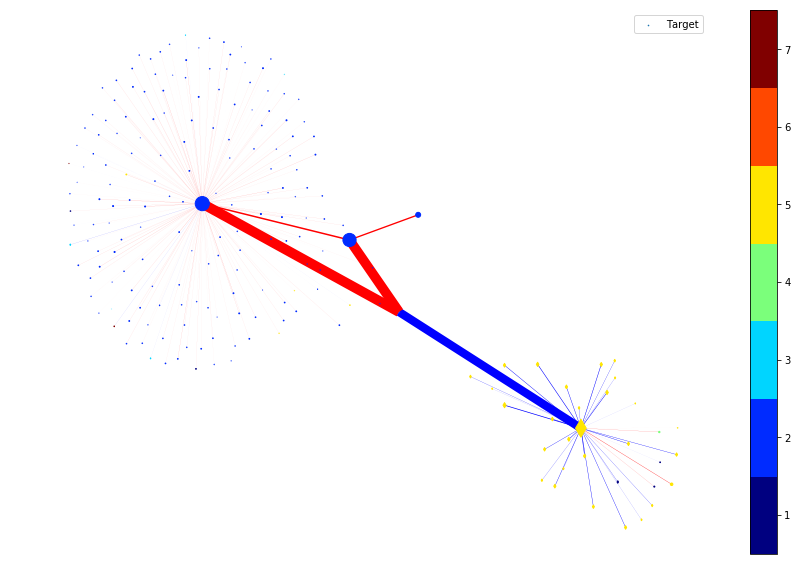

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10));
cmap = plt.get_cmap('jet', np.max(colors)-np.min(colors)+1)
# Draw the target node as a large star colored by its true subject
nx.draw_networkx_nodes(G_ego, pos, nodelist=[target_nid], node_size=50*abs(node_sizes[nodes.index(target_nid)]), node_color=[colors[nodes.index(target_nid)]], cmap=cmap, 
                       node_shape='*', vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, label="Target")
# Draw the ego net
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=positive_nodes, node_color=positive_colors, cmap=cmap, node_size=positive_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='o')
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=negative_nodes, node_color=negative_colors, cmap=cmap, node_size=negative_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='d')

#link_width_scale is used for better visulization of links
link_width_scale = link_width_factor/np.max(ground_truth_edge_importance)
weights = np.array([link_width_scale*ground_truth_edge_importance_counter[(u,v)] for u,v in edges])
weights += np.array([link_width_scale*ground_truth_edge_importance_counter[(v,u)] for u,v in edges])
weights = weights.tolist()
edge_colors = ['red' if weights[i] > 0 else 'blue' for i in range(len(weights))]

ec = nx.draw_networkx_edges(G_ego, pos, edge_color=edge_colors, width = weights)
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors),np.max(colors)+1))
plt.axis('off')
plt.show()